# RA2CE basics: set up RA2CE and configure a road network from a pre-defined shapefile

This notebook contains examples for the RA2CE tool. This requires the right folder setup, and the correct settings in the configuration files (network.ini and analyses.ini).

In this notebook, we will guide you through the basics of RA2CE: configuring a road network based in a pre-defined shapefile 

First of all, we will import the packages we need to execute this notebook:

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from ra2ce.ra2ce_handler import Ra2ceHandler # import the ra2cehandler to run ra2ce analyses

## Folder structure

Before starting the examples, it is vital that you familiarize yourself with the RA2CE folder structure. RA2CE requires this folder structure to succesfully perform analyses. You can find the folder structure in the **documentation**.


A project folder must contain the subfolders 'output' and 'static'. An 'input' folder is optional for additional data sets but we will not use that in our example. It must also contain the network.ini and/or analyses.ini files. Within the subfolder 'static', RA2CE expects three subfolders: hazard, network, and output_graph. See below an example folder structure of “Project A”. This folder structure must be created by the user before running RA2CE.

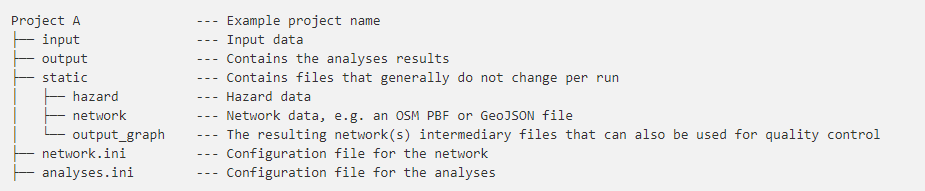

## Configuring RA2CE to create a road network from SHP

You can input an existing shapefile into RA2CE to create a network from it. Make sure the shapefile is in the WGS84 EPSG:4326 projection. Also ensure that the shapefile is 'clean' and connected.

### Filling the network.ini file
Now, we will fill the *network.ini* file with our configurations.

Under [project], we simply specify the *project name*. 

We then move on to the [network] section, where we will first mention the most important settings for this example. First, we specify the **source** of the procedure. In this case, you want to specify ***source = shapefile**. Specify the shapefile's name in the **primary_file** parameter. Make sure you saved the shapefile in your static/network folder. 

Some other important settings in the [network] section are:
- **directed**: Used together with OSM download - False if you want to have an undirected graph and True if you want to have a directed graph.
- **primary_file**: Used to specify the shapefile name of the (road) network to do the analysis with, when creating a network from a shapefile.
- **diversion_file**: Used to specify a shapefile name of the (road) network to only use for diversion (i.e., no analysis), when creating a network from a shapefile.
- **file_id**: The field name in the shapefile/OSM data that holds the unique ID of the data. When this ID attribute is not unique, RA2CE will create a new attribute in the data with the name 'rfid_c' (RA2CE feature ID complex) that contains the unique ID. For more information, the documentation on this is coming soon...
- **network_type**: The type of network to download from OSM, in the case of road networks, this must be set to *'drive'*.
- **save_gpkg**: True if you want to save the shapefile of the resulting road network in the *output_graph* folder.

The other settings [origins_destinations], [hazard], and [cleanup], are not relevant for this example and will be introduced in other examples. However, the parameters need to be in the network.ini file in order for RA2CE to run.

> [project]<br>
name = *insert your project name* <br>
<br>
[network]<br>
directed = False<br>
**source = shapefile<br>**
**primary_file = base_shapefile.shp**<br>
diversion_file = None<br>
**file_id = rfid_c**<br>
link_type_column = highway<br>
polygon = None<br>
network_type = drive<br>
road_types = None<br>
**save_gpkg = True**<br>
<br>
*[origins_destinations]<br>
origins = None<br>
destinations = None<br>
origins_names = None<br>
destinations_names = None<br>
id_name_origin_destination = None<br>
origin_count = None<br>
origin_out_fraction = None<br>
<br>
[hazard]<br>
hazard_map = None<br>
hazard_id = None<br>
hazard_field_name = None<br>
aggregate_wl = None<br>
hazard_crs = None  <br>
<br>
[cleanup]<br>
snapping_threshold = None <br>
segmentation_length = None <br>
merge_lines = True <br>
merge_on_id = False <br>
cut_at_intersections = False <br>*

Now, we tell the program where to find our project folder (by specifying the path to the project folder). Now that we introduced a polygon of a region and provided the right network.ini settings, RA2CE can download from OSM. 

For this action we only need the network.ini file, no analysis.ini file is needed.

In [ ]:
# specify the name of the path to the project folder where you created the RA2CE folder setup
root_dir = Path("data", "base_network_gpkg")
assert root_dir.exists()

In [ ]:
_network_ini_name = "network.ini" # set the name for the network.ini settings file
network_ini = root_dir / _network_ini_name #let RA2CE find the network.ini
assert network_ini.is_file() # check whether the network.ini file exists

## Creating the network with RA2CE
Initiate the RA2CE model through the Ra2ceHandler and configure (create) the network. Because we do not input the analysis.ini for now, we set that to *None*.

*Beware, it may take a while!*

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=None)
handler.input_config.network_config.config_data.network.link_type_column = "highway"
handler.configure()

## Inspecting the resulting network
Now, let's inspect the created network. Note: the road network is always saved in the static/output_graph folder.<br> 

First, we load the right geopackage. There are many geopackages created in the static / output_graph folder if you specify save_gpkg = True in the network.ini. These all represent some properties of the network. Let's inspect some of these.

*Notice the different files in the output_graph folder. You can inspect them all and see what their differences are.* 

In [ ]:
# Set the path to your output_graph folder to find the network/graph creation:
path_output_graph = root_dir / "static" / "output_graph"

In [ ]:
# Now we find and inspect the file 'base_graph_edges.gpkg' which holds the 'edges' of the network. 
# An edge (or link) of a network (or graph) represents a connection between two nodes (or vertices) of the network. More information on: https://mathinsight.org/definition/network_edge#:~:text=An%20edge%20(or%20link)%20of,in%20the%20first%20figure%20below.
base_graph_edges = path_output_graph / "base_network.gpkg"
edges_gdf = gpd.read_file(base_graph_edges, driver = "GPKG")
edges_gdf.head()

In [ ]:
edges_gdf.explore(tiles="CartoDB positron", popup = True)

*If you want to get a bit more advanced, use the 'Disconnected Islands' plugin in QGIS to check whether the road network is completely connected. If there are disconnected islands in the road network, this can impact more advanced RA2CE analyses (such as Origin-Destination analyses which are introduced in another example)*.

Now we find and inspect the file 'base_graph_nodes.gpkg' which holds the 'nodes' of the network. A node is represents the beginning and end point of an edge and can connect to one or multiple edges. Together, the nodes and edges make up the graph/network.

In [ ]:
base_graph_nodes = path_output_graph / "base_graph_nodes.gpkg" #specify where to find the nodes file
nodes_gdf = gpd.read_file(base_graph_nodes, driver = "GPKG") #read in the nodes file

#Plotting nodes and edges together
fig, ax = plt.subplots(figsize=(15, 15))  # Set the figsize as desired

# Set the edges as the base plot
baseplot = edges_gdf.plot(ax=ax, color='grey')
nodes_gdf.plot(ax=baseplot, color='blue', markersize=20)
plt.show()
